In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# return a trimmed copy of the dataframe containing only the defence exp data
def trim_df(df):
    category_length = len(df) // 2
    df_copy= df.copy()
    
    trimmed_df = df_copy.iloc[:category_length, :2]
    
    return trimmed_df

# create a dataframe containing the successful number of hits, the sample size (n) and an estimator for p (p_hat)
# where p_hat is an estimate for the probability of hitting a 1 with either an Event RPG or Iron Scimitar
def get_probability_df(df, weapon_type):
    attack_speed = {   "Event RPG"   : 1.8,  # Event RPG attacks once every 1.8s 
                     "Iron Scimitar" : 2.4 } # Iron Scimitar attacks once every 2.4s
    #df_length = len(df)
    
    #p_hat = np.zeros(df_length - 1)
    #df["Successful Hits"] = np.zeros(df_length)
    #df['n'] = np.zeros(df_length) #initialize 'n' total attacks
    
    successful_attacks = df.loc[1:, "Exp Gained"].to_numpy() / 4
    total_attacks = df.loc[1:, "Time (min)"].to_numpy() * 60 / attack_speed[weapon_type]
    total_attacks = [math.floor(attacks) for attacks in total_attacks]
    p_hat = successful_attacks / total_attacks
    
    d = { "Successful Attacks" : successful_attacks,
          "Total Attacks"      : total_attacks,
          "p hat"              : p_hat }
    
    probability_df = pd.DataFrame(data = d)
    
    return probability_df

def combine_df(df1, df2):
    df1_copy = df1.copy()
    df2_copy = df2.copy()
    
    df1_copy["Weapon Type"], df2_copy["Weapon Type"] = np.zeros(len(df1)), np.zeros(len(df1))
    df1_copy.loc[:, "Weapon Type"] = "Event RPG"
    df2_copy.loc[:, "Weapon Type"] = "Iron Scimitar"
    
    combined_df = df1_copy.append(df2_copy)
    
    return combined_df  

In [3]:
# load processed data
processed_rpg_df = pd.read_csv("data/processed_rpg_data.csv")
processed_scim_df = pd.read_csv("data/processed_scim_data.csv")

In [19]:
# transform data 
trimmed_rpg_df = trim_df(processed_rpg_df)
trimmed_scim_df = trim_df(processed_scim_df)

# calculate and add the probabilities of hitting a 1 to the dataframes
rpg_probability_df = get_probability_df(trimmed_rpg_df, "Event RPG")
scim_probability_df = get_probability_df(trimmed_scim_df, "Iron Scimitar")

# transform data for visualization
combined_df = combine_df(rpg_probability_df, scim_probability_df)
combined_df_length = int(len(combined_df))

In [16]:
# Event RPG sample size, p estimator and q
rpg_row = combined_df_length // 2 - 1
rpg_n, rpg_p_hat = combined_df.iloc[rpg_row, 1], combined_df.iloc[rpg_row, 2]
rpg_p_hat = round(rpg_p_hat, 6)
rpg_q = 1 - rpg_p_hat

print("--- Event RPG --- ")
print("    n:", rpg_n)
print("p_hat:", rpg_p_hat)
print("    q:", rpg_q)

--- Event RPG --- 
    n: 6000
p_hat: 0.190167
    q: 0.809833


In [17]:
# Iron Scimitar sample size, p estimator and q
scim_row = combined_df_length - 1
scim_n, scim_p_hat = combined_df.iloc[scim_row, 1], combined_df.iloc[scim_row, 2]
scim_p_hat = round(scim_p_hat, 6)
scim_q = 1 - scim_p_hat

print("--- Iron Scimitar --- ")
print("    n:", scim_n)
print("p_hat:", scim_p_hat)
print("    q:", scim_q)

--- Iron Scimitar --- 
    n: 4500
p_hat: 0.214889
    q: 0.785111


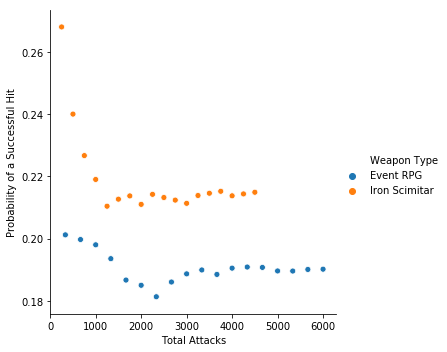

In [18]:
# visualize trend of p_hat as sample size n increases 
success_scatter = sns.relplot(x = "Total Attacks" ,
                              y = "p hat",
                              hue = "Weapon Type",
                              data = combined_df)

success_scatter.set(xlabel = "Total Attacks",
                    ylabel = "Probability of a Successful Hit")

plt.xlim(5, None)
plt.show()